Exercise 3: Mel-Frequency Cepstral Coefficent (MFCC)

In [1]:
import math
from math import log
import numpy as np
from scipy.io import wavfile
from scipy.signal import hamming
from scipy.fft import fft
import matplotlib.pyplot as plt
from matplotlib import cm

To recap, the MFCC extraction pipeline we covered in lecture consists of the following steps: 
1. Load an audio waveform.
2. DC subtraction (i.e. remove the mean of the signal)
3. Pre-emphasis filtering
4. Transforming the audio into a sequence of frames 
5. For each frame:

    (a) Multiplying the frame with a window function
    
    (b) Computing the Fourier transform
    
    (c) Computing the magnitude spectrum from the Fourier transform 
    
    (d) Computing the power spectrum from the magnitude spectrum 
    
    (e) Binning the power spectrum with Mel filterbanks
    
    (f) Taking the logarithm of the Mel-filterbank power spectrum
    
    (g) Computing Discrete Cosine Transform (DCT) of the log-Mel-power spectrum 
    
    (h) Truncating the DCT to keep only the first 𝐶 elements

Loading the Audio File:

In [2]:
def load_wav(filename):
    samplerate, data = wavfile.read('signal.wav')
    print("sample rate: ", samplerate)
    print("samples: ", data.shape[0])
    length = data.shape[0] / samplerate
    print(f"length= {length}s")
    return samplerate, data

Mean Subtraction:

In [3]:
def mean_subtract(data):
    return data - np.mean(data)

Pre-emphasis

x3[n] = x2[n] - bx2[n-1]

In [4]:
def compute_pre_emphasis(subtracted_data, alpha=0.97):
    pre_emphasis = []
    pre_emphasis.append(subtracted_data[0])
    for i in range(1, len(subtracted_data)):
        pre_emphasis.append(subtracted_data[i] - (alpha * subtracted_data[i-1]))
    pre_emphasis = np.array(pre_emphasis)
    return pre_emphasis

Computing Frames:

In [5]:
def frame_computation(signal, window_length, window_shift):
    
    samples = len(signal)
    num_frames = math.ceil((samples - window_length) / window_shift)
    frames = []
    for i in range (num_frames):
        frame = []
        for j in range(window_length):
            frame.append(signal[i * window_shift + j])
        frames.append(frame)
    # fill final frame with the remaining samples and append 0s to make it complete

    final_frame = []
    last_idx = num_frames * window_shift
    print(samples - len(signal[last_idx:]))
    for i in range(window_length):
        if last_idx + i < samples:
            final_frame.append(signal[last_idx + i])
        else:
            final_frame.append(0)
    frames.append(final_frame)
    return frames

Applying the window function:

In [6]:
def window_apply(frame):
    sig_hamming = hamming(len(frame))
    applied_frame = []
    for i in range(len(frame)):
        applied_frame.append(frame[i] * sig_hamming[i])
    return applied_frame

Computing the Fourier Transform

In [7]:
def fourier_transform(applied_frame):
    return fft(applied_frame, 512)

Computing the magnitude and power spectra

In [8]:
def power_spectra(fourier):
    pow_spec = []
    for i in range(len(fourier)):
        pow_spec.append(np.abs(fourier[i]) * np.abs(fourier[i]))
    return pow_spec

Mel-filterbank application

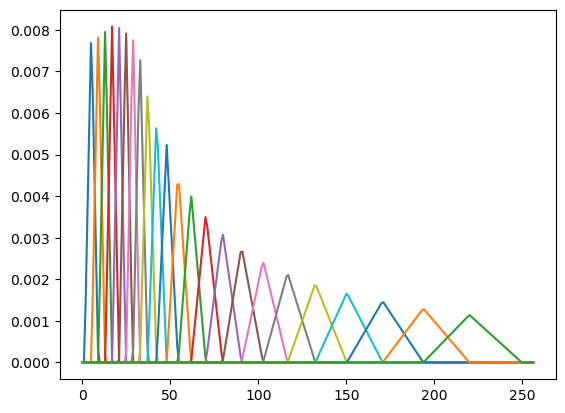

In [9]:
mel_filters = np.load("mel_filters.npy")
plt.plot(mel_filters.T)
plt.show()

In [10]:
def mel_energy(power_spectra):
    mel_energy = []
    for i in range(23):
        sum = 0
        for j in range(257):
            sum += mel_filters[i][j] * power_spectra[j]
        mel_energy.append(sum)
    return mel_energy

Taking the log

In [11]:
def log_mel(mel_energy):
    mel_energy_log = []
    for i in range(23):
        mel_energy_log.append(max(-50, log(mel_energy[i])))
    return mel_energy_log

Computing the DCT and "liftering"

In [12]:
def dct(mel_energy_log):
    dct_coefficients = []
    for i in range(13):
        sum = 0
        for k in range(23):
            sum += mel_energy_log[k] * math.cos((math.pi * i / 23 ) * (k + .5))
        dct_coefficients.append(sum)
    return dct_coefficients


Putting it all together

In [13]:
def mfcc(filename, window_len, window_shift):
    samplerate, data = load_wav(filename)
    subtracted_data = mean_subtract(data)
    pre_emphasis = compute_pre_emphasis(subtracted_data)
    frames = frame_computation(pre_emphasis, window_len, window_shift)
    # frames is a list of frames, each frame is a list of samples
    frames = np.array(frames)
    print(frames.shape)

    applied_frames = []
    for i in range(len(frames)):
        applied_frames.append(window_apply(frames[i]))
    # applied_frames is a list of frames, each frame is a list of samples

    fourier_transforms = []
    for i in range(len(applied_frames)):
        fourier_transforms.append(fourier_transform(applied_frames[i]))
    # fourier_transforms is a list of frames, each with 512 dft points

    power_spectrums = []
    for i in range(len(fourier_transforms)):
        power_spectrums.append(power_spectra(fourier_transforms[i]))

    mel_energies = []
    for i in range(len(power_spectrums)):
        mel_energies.append(mel_energy(power_spectrums[i]))

    mel_energies_logs = []
    for i in range(len(mel_energies)):
        mel_energies_logs.append(log_mel(mel_energies[i]))

    dct_coefficents_list = []
    for i in range(len(mel_energies_logs)):
        dct_coefficents_list.append(dct(mel_energies_logs[i]))

    dct_coefficents_list = np.array(dct_coefficents_list)
    dct_transpose = dct_coefficents_list.T
    all_but = dct_transpose[1:]

    plt.imshow(all_but, aspect='auto', origin='lower')
    plt.title("MFCC")
    plt.ylabel("Cepstral Coefficients")
    plt.xlabel("Frames")
    plt.colorbar()

    plt.show()
    return (
        np.array(frames), 
        np.array(applied_frames),
        np.array(fourier_transforms),
        np.array(power_spectrums),
        np.array(mel_energies),
        np.array(mel_energies_logs),
        np.array(dct_coefficents_list).T
    )


In [14]:
window_len = 400
window_shift = 160
mfcc_results = mfcc('signal.wav', window_len, window_shift)


sample rate:  16000
samples:  18091
length= 1.1306875s


IndexError: index 18091 is out of bounds for axis 0 with size 18091

(112, 13)


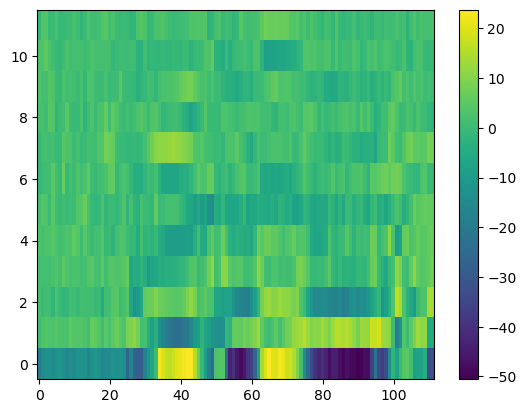

In [ ]:
ref_mfcc = np.load("reference_mfcc.npy")
print(ref_mfcc.shape)

ref_mfcc_trans = ref_mfcc.T
ref_mfcc_cutoff = ref_mfcc_trans[1:]

# plt.plot(ref_mfcc)
plt.imshow(ref_mfcc_cutoff, aspect='auto', origin='lower')
plt.colorbar()
plt.show()

visualize and difference

(112, 13)
mean squared error: 2.0890948240907352e-26


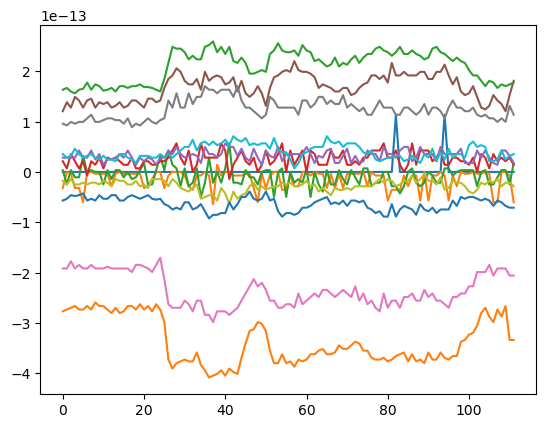

In [ ]:
error = ref_mfcc - mfcc_results[-1].T

print(error.shape)

mse = np.mean(np.square(error))
print('mean squared error:', mse)

plt.plot(error)
plt.show()

last plots

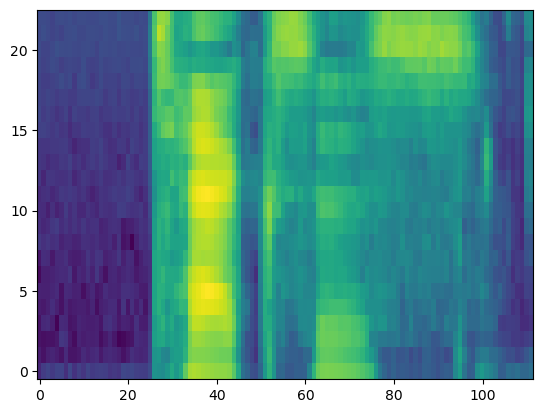

In [ ]:
mel_energies_logs = mfcc_results[-2]
plt.imshow(mel_energies_logs.T, aspect='auto', origin='lower')
plt.show()

In [ ]:
def log_power_spectrum(power_specs):
    log_power_spectrum_list = []
    for i in range(len(power_specs)):
        log_power_spectrum_list.append([])
        for j in range(len(power_specs[i])):
            log_power_spectrum_list[i].append(max(-50, log(power_specs[i][j])))

    return np.array(log_power_spectrum_list)

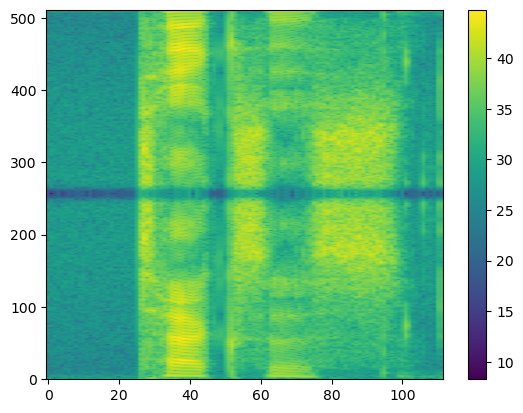

In [ ]:
power_specs = mfcc_results[3]
log_power_spectrum_list = log_power_spectrum(power_specs)

plt.imshow(log_power_spectrum_list.T, aspect='auto', origin='lower')
plt.colorbar()
plt.show()

Comment on how these two spectra look different????

sample rate:  16000
samples:  18091
length= 1.1306875s
18032
(1128, 64)


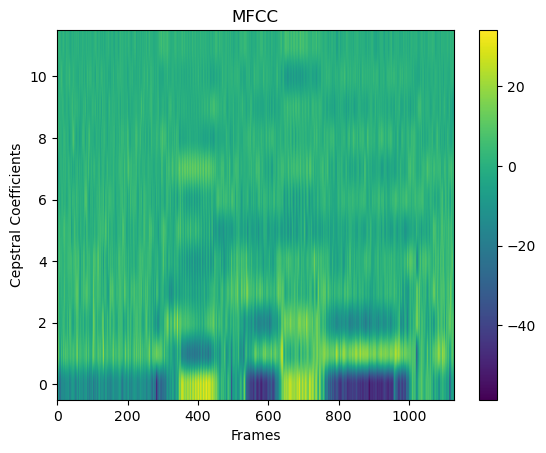

In [ ]:
window_len = 64
window_shift = 16
mfcc_results = mfcc('signal.wav', window_len, window_shift)

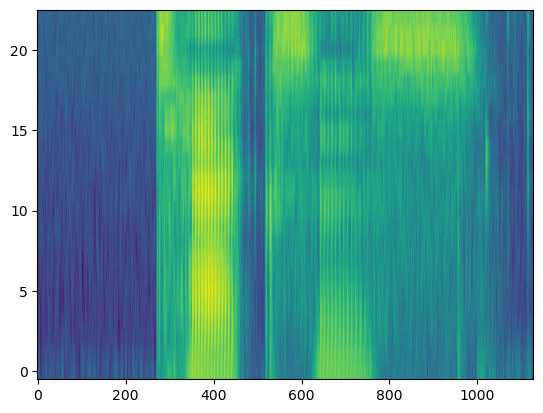

In [ ]:
mel_energies_logs = mfcc_results[-2]
plt.imshow(mel_energies_logs.T, aspect='auto', origin='lower')
plt.show()

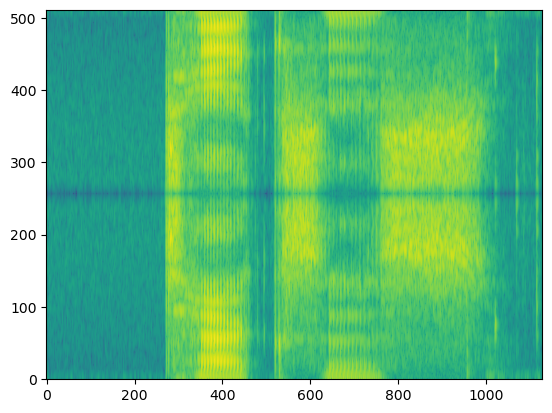

In [ ]:
power_specs = mfcc_results[3]
log_power_spectrum_list = log_power_spectrum(power_specs)

plt.imshow(log_power_spectrum_list.T, aspect='auto', origin='lower')
plt.show()

How does the spectrum look different when using 25 millisecond windows as opposed to 4 millisecond windows? Why does this happen? Include both of these plots in your writeup.

Finally, make a plot of 𝐶1 as a function of time and include this plot in your writeup. What do you notice about the value that 𝐶1 takes on during a vowel vs. during a fricative? Why is this the case? Hint: closely examine the DCT equation for 𝑖 = 1. You might find it useful to plot the cosine term in the equation for 𝑖 = 1.

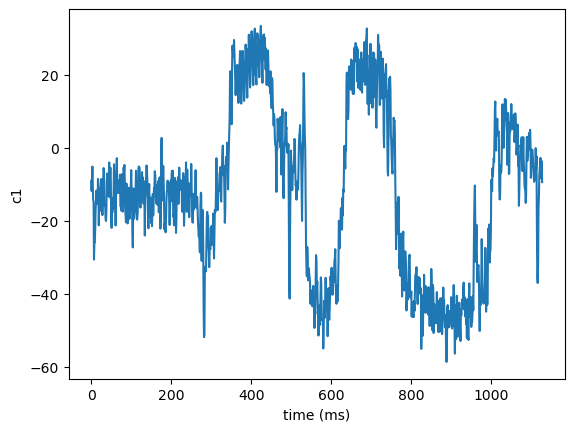

In [ ]:
dct_coefs = mfcc_results[-1]
c1 = dct_coefs[1]

# plot c1 over time
plt.plot(c1)



# add labels
plt.xlabel('time (ms)')
plt.ylabel('c1')
plt.show()